In [1]:
%matplotlib inline

1. Predict with pre-trained Simple Pose Estimation models
==========================================

This article shows how to play with pre-trained Simple Pose models with only a few
lines of code.

First let's import some necessary libraries:


In [2]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

Load a pretrained model
-------------------------

Let's get a Simple Pose model trained with input images of size 256x192 on MS COCO
dataset. We pick the one using ResNet-18 V1b as the base model. By specifying
``pretrained=True``, it will automatically download the model from the model
zoo if necessary. For more pretrained models, please refer to
:doc:`../../model_zoo/index`.

Note that a Simple Pose model takes a top-down strategy to estimate
human pose in detected bounding boxes from an object detection model.



In [3]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

Model file is not found. Downloading.


88993KB [00:28, 3077.91KB/s]                           


Model file is not found. Downloading.


55763KB [00:19, 2899.18KB/s]                           


Pre-process an image for detector, and make inference
--------------------

Next we download an image, and pre-process with preset data transforms. Here we
specify that we resize the short edge of the image to 512 px. But you can
feed an arbitrarily sized image.

This function returns two results. The first is a NDArray with shape
``(batch_size, RGB_channels, height, width)``. It can be fed into the
model directly. The second one contains the images in numpy format to
easy to be plotted. Since we only loaded a single image, the first dimension
of `x` is 1.



In [4]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

1562KB [01:42, 15.20KB/s]                          


Shape of pre-processed image: (1, 3, 512, 605)


Process tensor from detector to keypoint network
--------------------

Next we process the output from the detector.

For a Simple Pose network, it expects the input has the size 256x192,
and the human is centered. We crop the bounding boxed area
for each human, and resize it to 256x192, then finally normalize it.

In order to make sure the bounding box has included the entire person,
we usually slightly upscale the box size.



In [5]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

Predict with a Simple Pose network
--------------------

Now we can make prediction.

A Simple Pose network predicts the heatmap for each joint (i.e. keypoint).
After the inference we search for the highest value in the heatmap and map it to the
coordinates on the original image.



In [6]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

Display the pose estimation results
---------------------

We can use :py:func:`gluoncv.utils.viz.plot_keypoints` to visualize the
results.



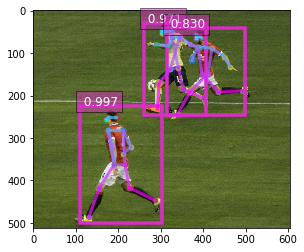

In [7]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.show()